## 回归分析
最基本的回归分析方法是线性回归(linear regression)，它是通过线性函数对变量间定量关系进行统计分析。比如广告的投入金额与获客数量，就可能呈现出线性关系

![image.png](image.png)

<center>广告投入/新注册用户数</center>


### 问题定义  
> 背景：  
- 某电商记录了过去12个月的用户数据  
- 订单信息包括：用户名、所购物品、金额、时间等

> 问题：  
- 如何根据历史数据，确定**类型用户**的生命周期价值？

### 数据准备

In [36]:
import numpy as np
import pandas as pd

df_sales=pd.read_csv('电商历史订单.csv')
df_sales

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2022 9:09,绿联usb分线器 一拖四,32,10.95,15100,北京
1,536376,22114,6/1/2022 9:32,加大男装T恤男大码胖子宽松卡,48,50.45,15291,上海
2,536376,21733,6/1/2022 9:32,唐装男夏季青年棉麻中国风加肥,64,86.55,15291,上海
3,536378,22386,6/1/2022 9:37,越南进口白心火龙果4个装,10,108.95,14688,北京
4,536378,85099C,6/1/2022 9:37,大连美早樱桃400g 果径约26mm,10,166.95,14688,北京
...,...,...,...,...,...,...,...,...
87175,581585,21684,6/9/2023 12:31,后续产品说明已经脱敏,12,0.85,15804,深圳
87176,581585,22398,6/9/2023 12:31,后续产品说明已经脱敏,12,0.39,15804,深圳
87177,581585,23328,6/9/2023 12:31,后续产品说明已经脱敏,4,3.75,15804,深圳
87178,581585,23145,6/9/2023 12:31,后续产品说明已经脱敏,12,0.95,15804,深圳


### 特征工程  
- 把原始订单数据转换为每一个**用户**的R、M、F值，其作为用户的生命周期价值（LTV）的参数  
- 把R、M、F层级作为特征，训练机器学习模型
- R：新进度，衡量这个用户近期是否在这消费了-Recency；R值越大说明消费的日期约近
- M：消费额，用户消费的金钱
- F：频次，用户消费的次数

### 模型选择  
- 线性回归模型
- 决策树回归模型
- 随机森林回归模型


## 数据整理
> 数据缺乏总价列  
> 数据的日期格式有问题

In [37]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87180 entries, 0 to 87179
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   订单号     87180 non-null  object 
 1   产品码     87180 non-null  object 
 2   消费日期    87180 non-null  object 
 3   产品说明    87180 non-null  object 
 4   数量      87180 non-null  int64  
 5   单价      87180 non-null  float64
 6   用户码     87180 non-null  int64  
 7   城市      87180 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 5.3+ MB


### 计算每单的总价，因为源数据中没有提供

In [38]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价']

In [39]:
df_sales

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,6/1/2022 9:09,绿联usb分线器 一拖四,32,10.95,15100,北京,350.40
1,536376,22114,6/1/2022 9:32,加大男装T恤男大码胖子宽松卡,48,50.45,15291,上海,2421.60
2,536376,21733,6/1/2022 9:32,唐装男夏季青年棉麻中国风加肥,64,86.55,15291,上海,5539.20
3,536378,22386,6/1/2022 9:37,越南进口白心火龙果4个装,10,108.95,14688,北京,1089.50
4,536378,85099C,6/1/2022 9:37,大连美早樱桃400g 果径约26mm,10,166.95,14688,北京,1669.50
...,...,...,...,...,...,...,...,...,...
87175,581585,21684,6/9/2023 12:31,后续产品说明已经脱敏,12,0.85,15804,深圳,10.20
87176,581585,22398,6/9/2023 12:31,后续产品说明已经脱敏,12,0.39,15804,深圳,4.68
87177,581585,23328,6/9/2023 12:31,后续产品说明已经脱敏,4,3.75,15804,深圳,15.00
87178,581585,23145,6/9/2023 12:31,后续产品说明已经脱敏,12,0.95,15804,深圳,11.40


### 调整数据的日期格式

In [40]:
#先输出日期范围，观察日期格式:实际上是String类型
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(),df_sales['消费日期'].max()))

日期范围: 1/1/2023 10:11 ~ 9/9/2022 9:20


In [41]:
#转换格式日期格式
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(),df_sales['消费日期'].max()))

日期范围: 2022-06-01 09:09:00 ~ 2023-06-09 12:31:00


### 拆分三个月的数据做实验数据，训练模型；去推测未来的数据

In [42]:
df_sales_3m = df_sales[(df_sales.消费日期>'2022-06-01') & (df_sales.消费日期<='2022-08-30')]
df_sales_3m.reset_index(drop=True)# 重置索引

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2022-06-01 09:09:00,绿联usb分线器 一拖四,32,10.95,15100,北京,350.4
1,536376,22114,2022-06-01 09:32:00,加大男装T恤男大码胖子宽松卡,48,50.45,15291,上海,2421.6
2,536376,21733,2022-06-01 09:32:00,唐装男夏季青年棉麻中国风加肥,64,86.55,15291,上海,5539.2
3,536378,22386,2022-06-01 09:37:00,越南进口白心火龙果4个装,10,108.95,14688,北京,1089.5
4,536378,85099C,2022-06-01 09:37:00,大连美早樱桃400g 果径约26mm,10,166.95,14688,北京,1669.5
...,...,...,...,...,...,...,...,...,...
14837,545190,22937,2022-08-29 15:32:00,后续产品说明已经脱敏,6,2.50,15656,苏州,15.0
14838,545190,22722,2022-08-29 15:32:00,后续产品说明已经脱敏,40,3.00,15656,苏州,120.0
14839,545190,22457,2022-08-29 15:32:00,后续产品说明已经脱敏,6,5.00,15656,苏州,30.0
14840,545190,22464,2022-08-29 15:32:00,后续产品说明已经脱敏,12,3.00,15656,苏州,36.0


### 数据特征阶段
- 目标把每个订单数据转成每个用户数据RFM值

In [43]:
df_user_LTV = pd.DataFrame(df_sales_3m['用户码'].unique()) #生成以‘用户码’为主键的对象
df_user_LTV

,0
0,15100
1,15291
2,14688
3,15311
4,15862
...,...
365,15951
366,14745
367,15724
368,15874


In [44]:
df_user_LTV.columns = ['用户码'] #设定字段名
df_user_LTV

,用户码
0,15100
1,15291
2,14688
3,15311
4,15862
...,...
365,15951
366,14745
367,15724
368,15874


#### 计算R值，并加入LTV dataframe

In [45]:
# 找到每个用户的最近消费日期，构建df_R_value对象
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index()
# 加字段名
df_R_value.columns = ['用户码','最近购买日期']
#计算最新日期与上次消费日期期间的天数
df_R_value['R值']=(df_R_value['最近购买日期'].max()-df_R_value['最近购买日期']).dt.days

#把上次消费日期据最新日期的天数（R值）整合至df_user对象中
df_user_LTV = pd.merge(df_user_LTV,df_R_value[['用户码','R值']],on='用户码')

In [46]:
df_user_LTV

,用户码,R值
0,15100,45
1,15291,35
2,14688,6
3,15311,5
4,15862,89
...,...,...
365,15951,1
366,14745,1
367,15724,0
368,15874,0


In [47]:
#计算每个用户的消费次数，构建df_F_value 对象
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index()
#设定两个字段名
df_F_value.columns = ['用户码','F值']
#把上次消费频率(F值)整合至df_user对象中
df_user_LTV = pd.merge(df_user_LTV,df_F_value[['用户码','F值']],on='用户码')

In [48]:
df_user_LTV

,用户码,R值,F值
0,15100,45,7
1,15291,35,37
2,14688,6,88
3,15311,5,717
4,15862,89,59
...,...,...,...
365,15951,1,22
366,14745,1,7
367,15724,0,5
368,15874,0,5


In [49]:
# 计算每个用户前3 个月的消费总额，构建df_M_value 对象
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index()
#设定字段名
df_M_value.columns=['用户码','M值']
#把消费总额(M值)整合至df_user对象中
df_user_LTV = pd.merge(df_user_LTV,df_M_value,on='用户码')

In [51]:
df_user_LTV

,用户码,R值,F值,M值
0,15100,45,7,985.50
1,15291,35,37,16922.75
2,14688,6,88,14700.78
3,15311,5,717,12734.66
4,15862,89,59,1297.71
...,...,...,...,...
365,15951,1,22,375.17
366,14745,1,7,240.60
367,15724,0,5,103.65
368,15874,0,5,584.35


In [52]:
# 计算每个用户的整年消费总额(y值)，构建df_user_1y 对象
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index()
#设定字段名
df_user_1y.columns = ['用户码','年度LTV']

In [53]:
df_user_1y

,用户码,年度LTV
0,14681,498.95
1,14682,52.00
2,14684,1236.28
3,14687,628.38
4,14688,18335.88
...,...,...
980,16015,690.54
981,16016,1483.31
982,16017,211.88
983,16018,408.90


In [54]:
#计算整体LTV,训练数据集
df_LTV = pd.merge(df_user_LTV,df_user_1y,on='用户码',how= 'left')
df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,45,7,985.50,985.50
1,15291,35,37,16922.75,20189.31
2,14688,6,88,14700.78,18335.88
3,15311,5,717,12734.66,59423.99
4,15862,89,59,1297.71,1776.36
...,...,...,...,...,...
365,15951,1,22,375.17,669.57
366,14745,1,7,240.60,1167.16
367,15724,0,5,103.65,212.30
368,15874,0,5,584.35,4330.67


### 构建X,y值

In [56]:
#特征集
X = df_LTV.drop(['用户码','年度LTV'],axis=1)
X.head()

,R值,F值,M值
0,45,7,985.50
1,35,37,16922.75
2,6,88,14700.78
3,5,717,12734.66
4,89,59,1297.71


In [57]:
#标签集
y=df_LTV['年度LTV']
y.head()

0      985.50
1    20189.31
2    18335.88
3    59423.99
4     1776.36
Name: 年度LTV, dtype: float64

### 拆分训练集和测试集

In [59]:
#导入train_test_split
from sklearn.model_selection import train_test_split

- `X`是特征数据  
- `y`是目标变量或标签  
- `test_size=0.2`表示测试集占总数据的20%。  
- `random_state=7`确保每次运行代码时都能得到相同的分割结果，这对于实验的可重复性很有用。分割后，返回的四个变量分别是：训练集的特征、测试集的特征、训练集的标签和测试集的标签。

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

### 导入线性回归模块

In [61]:
#导入线性回归模块
from sklearn.linear_model import LinearRegression
model = LinearRegression()

### 拟合模型  
- 用训练集拟合
- 确定了a:斜率,权重(w),b:截距,偏置(bias)

In [63]:
model.fit(X_train,y_train)

LinearRegression()

### 用模型预测测试集

- 使用训练好的模型来预测训练集的标签。这些预测值存储在变量y_train_preds中。  
- 这里有一个关键点：通常我们不使用模型来预测其训练数据，因为模型已经“看过”这些数据，预测它们可能会导致过拟合。

In [76]:
y_train_preds =  model.predict(X_train) # 用模型预测训练集

- 使用训练好的模型来预测测试集的标签。这些预测值存储在变量y_test_preds中。  
- 评估模型性能时，我们通常使用这些预测值与测试集的真实标签进行比较。

In [71]:
y_test_preds=model.predict(X_test) #

### 观察特征值,预测值,实际值 评估模型的可用性

In [68]:
X_test.iloc[2] # 随机选择一行数据

R值     83.00
F值     64.00
M值    521.69
Name: 80, dtype: float64

In [69]:
y_test_preds[2] #模型预测值

1376.3506740578205

In [70]:
y_test.iloc[2] #实际值

1384.68

In [73]:
from sklearn.metrics import r2_score, median_absolute_error #导入Sklearn评估模块
print('训练集上的R平方分数: %0.4f' % r2_score(y_true=y_train, y_pred=y_train_preds))
print('测试集上的R平方分数: %0.4f' % r2_score(y_true=y_test, y_pred=y_test_preds))

训练集上的R平方分数: 0.6187
测试集上的R平方分数: 0.4778


### 散点图表示预测
- 用实际值和模型预测值绘制散点图

Text(0.5, 1.0, ' 实际值与预测值')

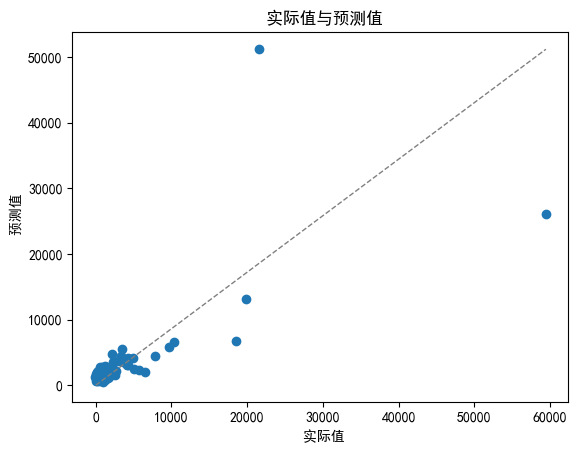

In [74]:
import matplotlib.pyplot as plt # 导入Matplotlib 的pyplot 模块
plt.rcParams["font.family"]=['SimHei'] #用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] #用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.scatter(y_test, y_test_preds) # 预测值和实际值的散点图
plt.plot([0, max(y_test)], [0, max(y_test_preds)], color='gray', lw=1, linestyle='--') # 绘图
plt.xlabel(' 实际值') #x 轴
plt.ylabel(' 预测值') #y 轴
plt.title(' 实际值与预测值') # 标题